In [0]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from collections import namedtuple
import matplotlib.pyplot as plt

In [0]:
# Set up your path accordingly 
train_csv = "drive/My Drive/Quant/train.csv"
depth_csv = "drive/My Drive/Quant/depths.csv"
train_images_path = "drive/My Drive/Quant/images"
train_masks_path = "drive/My Drive/Quant/masks"
root_path = "drive/My Drive/Quant"
images_npy_path = "drive/My Drive/Quant/images.npy"
masks_npy_path = "drive/My Drive/Quant/masks.npy"
model_save_path = "drive/My Drive/Quant/Models"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
file_list = os.listdir(train_images_path)
file_list = np.array(file_list)

In [0]:
def save_dict(path , dct):
    with open(path , "wb") as handle:
        pickle.dump(dct , handle , protocol = pickle.HIGHEST_PROTOCOL)
def load_dict(path):
    with open(path, "rb") as handle:
        b = pickle.load(handle)
    return b

In [0]:
class TGSSaltDataset(data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def load(self, file_id):
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id)
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id)

        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        image = cv2.resize(image , (128,128) )
        mask = cv2.resize(mask , (128,128))
        ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
        image = np.rollaxis(image , 2,0)

    
        return image , mask

    def get_array(self):
        photos = np.empty((len(self.file_list) ,3,128,128) , dtype = np.int16)
        masks =  np.empty((len(self.file_list) ,1,128,128) , dtype = np.int16)
        for i,im in enumerate(self.file_list):
            print(i)
            p , m = self.load(im)
            photos[i,:,:,:] = p
            masks[i,0,:,:] = m
        return photos, masks

In [0]:
dataset = TGSSaltDataset(root_path, file_list)

I have already extracted Images and cropped/resized for feeding in the U-net, I will directely load the images and the maskes, if you want to redo the process , just uncomment the first line in the next cell

In [0]:
#images , masks = dataset.get_array()    # save the images and masks you get from this to your disk. 
images = np.load(images_npy_path)
masks = np.load(masks_npy_path)

*First 3000 images are used for training and rest for testing*

In [0]:
def get_batch(batch_size , images , masks):   
    index = np.random.randint(0, len(images)- 1000 , batch_size)
    img = images[index]
    msk = masks[index]
    img = torch.tensor(img).float().to(device)/255
    msk = torch.tensor(msk).float().to(device)/255
    return img, msk
def get_test(images , mask):
    img = images[-1000:]
    msk = masks[-1000:]
    img = torch.tensor(img).float().to(device)/255
    msk = torch.tensor(msk).float().to(device)/255
    return img, msk



In [0]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

def plot2x2Array_compare(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Orignal_Mask')
    axarr[1].set_title('Predicted_Mask')

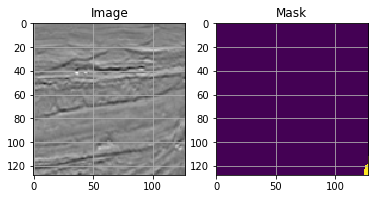

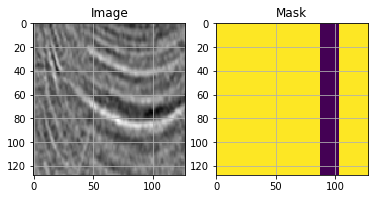

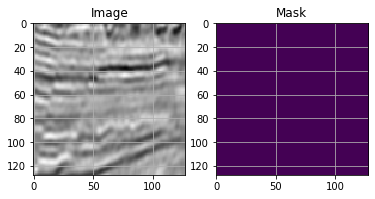

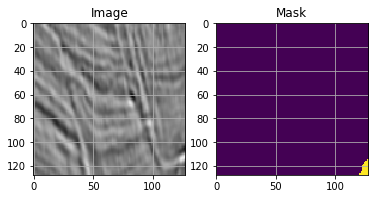

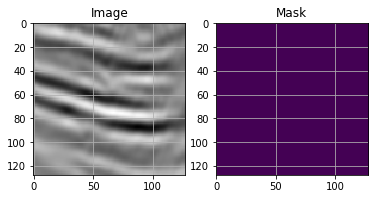

In [34]:
for i in range(5):    # PLotting the first 5 training examples. 
    image, mask = images[i] , masks[i]
    disp_img = np.rollaxis(image , 1, 0)
    disp_img = np.rollaxis(disp_img , 2, 1)

    disp_msk = np.rollaxis(mask , 1, 0)
    disp_msk = np.rollaxis(disp_msk , 2, 1)[:,:,0]
    
    plot2x2Array(disp_img, disp_msk)

In [0]:
class Salt_finder(nn.Module):   # This is the U-net for segmenting salt pixels 
    def __init__(self):
        super().__init__()
        # ----------  #
        self.conv1_1 = nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv1_2 = nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu1_1 = nn.ReLU()
        self.relu1_2 = nn.ReLU()
        self.MX1_1 = nn.MaxPool2d(2, stride=2)
        # ----------  #
        self.conv2_1 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv2_2 = nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu2_1 = nn.ReLU()
        self.relu2_2 = nn.ReLU()
        self.MX2_1 = nn.MaxPool2d(2, stride=2)

        # ----------  #
        self.conv3_1 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv3_2 = nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu3_1 = nn.ReLU()
        self.relu3_2 = nn.ReLU()
        self.MX3_1 = nn.MaxPool2d(2, stride=2)

        # ----------  #
        self.conv4_1 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv4_2 = nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu4_1 = nn.ReLU()
        self.relu4_2 = nn.ReLU()
        self.MX4_1 = nn.MaxPool2d(2, stride=2)

         # ----------  #
        self.conv5_1 = nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv5_2 = nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu5_1 = nn.ReLU()
        self.relu5_2 = nn.ReLU()


        # ----------  #
        self.up1 = nn.ConvTranspose2d(in_channels = 256 , out_channels= 128 , kernel_size= 2 , stride = 2 )
        # ----------  #
        self.conv6_1 = nn.Conv2d(in_channels= 256, out_channels= 128, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv6_2 = nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu6_1 = nn.ReLU()
        self.relu6_2 = nn.ReLU()

        # ----------  #
        self.up2 = nn.ConvTranspose2d(in_channels = 128 , out_channels= 64 , kernel_size= 2 , stride = 2 )

        # ----------  #
        self.conv7_1 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv7_2 = nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu7_1 = nn.ReLU()
        self.relu7_2 = nn.ReLU()

        # ----------  #
        self.up3 = nn.ConvTranspose2d(in_channels = 64 , out_channels= 32 , kernel_size= 2 , stride = 2 )

        # ----------  #
        self.conv8_1 = nn.Conv2d(in_channels= 64, out_channels= 32, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv8_2 = nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu8_1 = nn.ReLU()
        self.relu8_2 = nn.ReLU()

        # ----------  #
        self.up4 = nn.ConvTranspose2d(in_channels = 32 , out_channels= 16 , kernel_size= 2 , stride = 2 )

        # ----------  #
        self.conv9_1 = nn.Conv2d(in_channels= 32, out_channels= 16, kernel_size = (3,3), stride=1 , padding = 1)
        self.conv9_2 = nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size = (3,3), stride=1 , padding = 1)
        self.relu9_1 = nn.ReLU()
        self.relu9_2 = nn.ReLU()

        # ----------  #
        self.conv_final = nn.Conv2d(in_channels= 16, out_channels= 1, kernel_size = (1,1), stride=1 , padding = 0)

        self.sig = nn.Sigmoid()




    def forward(self ,X):
        c1 = self.conv1_1(X)
        c1 = self.relu1_1(c1)
        c1 = self.conv1_2(c1)
        c1 = self.relu1_2(c1)
        p1 = self.MX1_1(c1)

        c2 = self.conv2_1(p1)
        c2 = self.relu2_1(c2)
        c2 = self.conv2_2(c2)
        c2 = self.relu2_2(c2)
        p2 = self.MX2_1(c2)

        c3 = self.conv3_1(p2)
        c3 = self.relu3_1(c3)
        c3 = self.conv3_2(c3)
        c3 = self.relu3_2(c3)
        p3 = self.MX3_1(c3)

        
        c4 = self.conv4_1(p3)
        c4 = self.relu4_1(c4)
        c4 = self.conv4_2(c4)
        c4 = self.relu4_2(c4)
        p4 = self.MX4_1(c4)

        
        c5 = self.conv5_1(p4)
        c5 = self.relu5_1(c5)
        c5 = self.conv5_2(c5)
        c5 = self.relu5_2(c5)

        u6 = self.up1(c5)
        u6 = torch.cat((u6,c4) , dim = 1)

        c6 = self.conv6_1(u6)
        c6 = self.relu6_1(c6)
        c6 = self.conv6_2(c6)
        c6 = self.relu6_2(c6)

        u7 = self.up2(c6)
        u7 = torch.cat((u7,c3) , dim = 1)

        c7 = self.conv7_1(u7)
        c7 = self.relu7_1(c7)
        c7 = self.conv7_2(c7)
        c7 = self.relu7_2(c7)

        
        u8 = self.up3(c7)
        u8 = torch.cat((u8,c2) , dim = 1)

        c8 = self.conv8_1(u8)
        c8 = self.relu8_1(c8)
        c8 = self.conv8_2(c8)
        c8 = self.relu8_2(c8)

        u9 = self.up4(c8)
        u9 = torch.cat((u9,c1) , dim = 1)

        
        c9 = self.conv9_1(u9)
        c9 = self.relu9_1(c9)
        c9 = self.conv9_2(c9)
        c9 = self.relu9_2(c9)

        out = self.conv_final(c9)
        out = self.sig(out)
        return out


In [0]:
Model = Salt_finder().to(device)
crit = nn.BCELoss()
learning_rate = .00005
opt = torch.optim.Adam(Model.parameters(), lr=learning_rate)


In [0]:
def load_model(model):
    path = os.path.join(model_save_path , "Best_model.pt")
    model.load_state_dict(torch.load(path))
    return model

I have already trained the model and got a IOU score of 69%
If you want to train your own model do not run the next cell , but run the train cell instead

In [0]:
Model = load_model(Model)

In [0]:
def IOU_loss(logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [0]:
def get_accuracy(Model , inp , truth):
    with torch.no_grad():
        out = Model(inp)
        t = torch.Tensor([0.5]).to(device)  # threshold
        out = (out > t).float() * 1
    out = out.cpu().numpy()
    truth = truth.cpu().numpy()
    intersection = np.logical_and(truth, out)
    union = np.logical_or(truth, out)
    union = np.sum(union)
    intersection = np.sum(intersection)
    if(union == 0):
        return 1
    iou_score = np.sum(intersection) / np.sum(union)
    #accu = out == truth
    #accu = torch.sum(accu).item()
    accu = iou_score
    #total = inp.size(0)*128*128
    return accu#/total


def get_total_accuracy(Model , inp , truth):
    accu = 0
    for i in range(len(inp)):
        accu += get_accuracy(Model , inp[i:i+1] , truth[i:i+1] )
    return accu/len(inp) 


def get_image_data(out , actual):
    actual = actual.squeeze()
    actual = actual.cpu().numpy()
    t = torch.Tensor([0.5]).to(device)  # threshold
    out = (out > t).float() * 1
    out = out.squeeze()
    out = out.cpu().numpy()
    return out , actual
    


I use both binary cross entropy loss and IOU loss as presented in the paper http://www.insticc.org/Primoris/Resources/PaperPdf.ashx?idPaper=73475 to train the model.

In [0]:
IOU_array = []
def train(Model , epochs  , batch_size , opt , crit ,images , masks ):
    for _ in range(epochs):
        total_loss = 0
        times = len(images)//batch_size
        for _ in range(times):
            img , msk = get_batch(batch_size , images , masks)
            out = Model(img)
            opt.zero_grad() 
            loss = crit(out , msk) + IOU_loss(out , msk)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print("loss =" ,total_loss/times)
        inp = get_test(images  ,masks)
        print("Validation IOU score =" , end = " ")
        IOU_score = get_total_accuracy(Model , inp[0] , inp[1])
        IOU_array.append(IOU_score)
        print(IOU_score)
        print("")



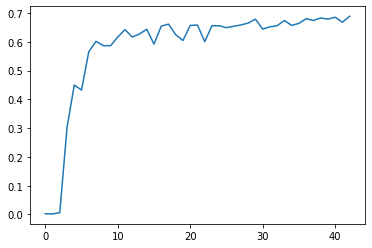

In [57]:
#train(Model , 40 , 32, opt, crit , images , masks)
#plt.plot(IOU_array)  # This is plot of validation IOU score vs epochs
#plt.show()


The above plot shows that my model gets 69% IOU score on validation set  

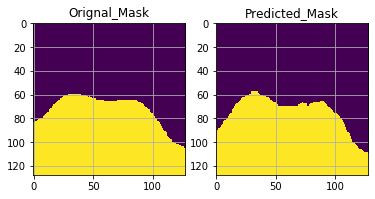

In [61]:
inp = get_batch(1 , images , masks)    # here is an example of predicted mask compared with orignal mask
out = Model(inp[0])
a,b  = get_image_data(out , inp[1])
plot2x2Array_compare(a , b)

## **Quantizing the network**

In [0]:
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, num_bits, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().int()
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

In [0]:
def quantizeLayer(x, layer, stat, scale_x, zp_x , num_bits):
  # for conv and deconv layers

  # cache old values
  W = layer.weight.data
  B = layer.bias.data

  # quantise weights, activations are already quantised
  w = quantize_tensor(layer.weight.data , num_bits = num_bits) 
  b = quantize_tensor(layer.bias.data , num_bits = num_bits)
  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  # This is Quantisation Artihmetic
  scale_w = w.scale
  zp_w = w.zero_point
  scale_b = b.scale
  zp_b = b.zero_point
  
  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'] , num_bits = num_bits)

  # Preparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = scale_x * scale_w*(layer.weight.data - zp_w)
  layer.bias.data = scale_b*(layer.bias.data - zp_b)

  # All int computation
  x = (layer(X)/ scale_next) + zero_point_next
  x = x.int() 
  x.clamp_(0, 2**num_bits - 1)
  
  # Reset weights for next forward pass
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next

Get Max and Min Stats for Quantising Activations of Network.
This is done by running the network with around 1000 examples and getting the average min and max activation values before and after each layer.

In [0]:
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)
  
  
  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1_1')
  x = F.relu(model.conv1_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1_2')
  x = F.relu(model.conv1_2(x))
  c1 = x.clone()
  x = F.max_pool2d(x, 2, 2)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2_1')
  x = F.relu(model.conv2_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2_2')
  x = F.relu(model.conv2_2(x))
  c2 = x.clone()
  x = F.max_pool2d(x, 2, 2)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3_1')
  x = F.relu(model.conv3_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3_2')
  x = F.relu(model.conv3_2(x))
  c3 = x.clone()
  x = F.max_pool2d(x, 2, 2)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4_1')
  x = F.relu(model.conv4_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4_2')
  x = F.relu(model.conv4_2(x))
  c4 = x.clone()
  x = F.max_pool2d(x, 2, 2)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5_1')
  x = F.relu(model.conv5_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5_2')
  x = F.relu(model.conv5_2(x))

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'up1')
  x = model.up1(x)
  x = torch.cat((x,c4) , dim = 1)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6_1')
  x = F.relu(model.conv6_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6_2')
  x = F.relu(model.conv6_2(x))

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'up2')
  x = model.up2(x)
  x = torch.cat((x,c3) , dim = 1)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7_1')
  x = F.relu(model.conv7_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7_2')
  x = F.relu(model.conv7_2(x))

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'up3')
  x = model.up3(x)
  x = torch.cat((x,c2) , dim = 1)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8_1')
  x = F.relu(model.conv8_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8_2')
  x = F.relu(model.conv8_2(x))

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'up4')
  x = model.up4(x)
  x = torch.cat((x,c1) , dim = 1)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv9_1')
  x = F.relu(model.conv9_1(x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv9_2')
  x = F.relu(model.conv9_2(x))

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv_final')
  x = torch.sigmoid(model.conv_final(x))

  return stats  

# Entry function to get stats of all functions.
def gatherStats(model, data_loader ,  images , masks):
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    img , msk  = data_loader(images , masks)
    with torch.no_grad():
        for i in range(len(img)):
            stats = gatherActivationStats(model, img[i:i+1], stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"] }
    return final_stats

In [0]:
dct = gatherStats(Model , get_test , images , masks)

In [0]:
dct

{'conv1_1': {'max': tensor(0.9535, device='cuda:0'),
  'min': tensor(0.0175, device='cuda:0')},
 'conv1_2': {'max': tensor(1.0010, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv2_1': {'max': tensor(0.4523, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv2_2': {'max': tensor(0.3679, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv3_1': {'max': tensor(0.3853, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv3_2': {'max': tensor(0.4817, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv4_1': {'max': tensor(1.0068, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv4_2': {'max': tensor(1.0342, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv5_1': {'max': tensor(2.9437, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv5_2': {'max': tensor(2.3765, device='cuda:0'),
  'min': tensor(0., device='cuda:0')},
 'conv6_1': {'max': tensor(2.9437, device='cuda:0'),
  'min': tensor(-0.5573

In [0]:
def quantForward(model, x, stats , n_bits):
  
  # Quantise before inputting into incoming layers
  x = quantize_tensor(x,num_bits= n_bits ,min_val=stats['conv1_1']['min'], max_val=stats['conv1_1']['max'])
  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1_1, stats['conv1_2'], x.scale, x.zero_point ,n_bits)
  return x
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv1_2, stats['conv2_1'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  c1 = x.clone()
  x = F.max_pool2d(x, 2, 2)


  x, scale_next, zero_point_next = quantizeLayer(x, model.conv2_1, stats['conv2_2'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv2_2, stats['conv3_1'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  c2 = x.clone()
  x = F.max_pool2d(x, 2, 2)

  x, scale_next, zero_point_next = quantizeLayer(x, model.conv3_1, stats['conv3_2'], scale_next, zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv3_2, stats['conv4_1'], scale_next, zero_point_next,n_bits)
  x =  F.relu(x)
  c3 = x.clone()
  x = F.max_pool2d(x, 2, 2)

  x, scale_next, zero_point_next = quantizeLayer(x, model.conv4_1, stats['conv4_2'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv4_2, stats['conv5_1'], scale_next, zero_point_next,n_bits)
  x =  F.relu(x)
  c4 = x.clone()
  x = F.max_pool2d(x, 2, 2)
    
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv5_1, stats['conv5_2'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv5_2, stats['up1'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  
  x, scale_next, zero_point_next = quantizeLayer(x, model.up1, stats['conv6_1'], scale_next, zero_point_next,n_bits)
  x = torch.cat((x,c4) , dim = 1)


  x, scale_next, zero_point_next = quantizeLayer(x, model.conv6_1, stats['conv6_2'], scale_next, zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv6_2, stats['up2'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.up2, stats['conv7_1'], scale_next, zero_point_next,n_bits)
  x = torch.cat((x,c3) , dim = 1)
  
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv7_1, stats['conv7_2'], scale_next, zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv7_2, stats['up3'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.up3, stats['conv8_1'], scale_next,zero_point_next,n_bits)
  x = torch.cat((x,c2) , dim = 1)

  x, scale_next, zero_point_next = quantizeLayer(x, model.conv8_1, stats['conv8_2'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv8_2, stats['up4'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.up4, stats['conv9_1'], scale_next,zero_point_next,n_bits)
  x = torch.cat((x,c1) , dim = 1)

  x, scale_next, zero_point_next = quantizeLayer(x, model.conv9_1, stats['conv9_2'], scale_next, zero_point_next,n_bits)
  x =  F.relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.conv9_2, stats['conv_final'], scale_next,zero_point_next,n_bits)
  x =  F.relu(x)

  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
  x = model.conv_final(x)
  x = torch.sigmoid(x)

  return x



In [0]:
test = get_batch(1, images , masks)

In [0]:
ans = quantForward(Model,test[0] , dct , 8)

(array([1.75000e+02, 8.12100e+03, 1.75499e+05, 3.38947e+05, 6.55820e+04,
        1.43200e+03, 5.70000e+01, 7.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([-0.09095169, -0.06369101, -0.03643034, -0.00916966,  0.01809101,
         0.04535169,  0.07261236,  0.09987304,  0.12713371,  0.15439439,
         0.18165506], dtype=float32),
 <a list of 10 Patch objects>)

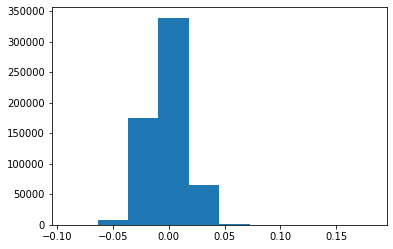

In [0]:
plt.hist(Model.conv5_2.weight.clone().view([1,-1]).detach().cpu())


In [0]:
q = quantize_tensor(Model.conv5_2.weight.clone().view([1,-1]).detach().cpu() , 8)

(array([1.7600e+02, 7.6490e+03, 1.7706e+05, 3.3370e+05, 6.9758e+04,
        1.4110e+03, 5.9000e+01, 7.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

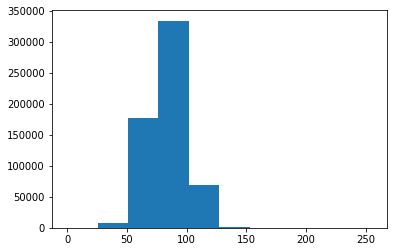

In [0]:
plt.hist(q.tensor)

In [0]:
test_item = get_batch(1 , images , masks)

In [0]:
def tensor_hist(tensor):
    ten = tensor.view([-1,1]).clone().detach().cpu()
    plt.hist(ten)
    plt.show()

In [0]:
def Q_run(model , test_item):
    with torch.no_grad():
        x = quantize_tensor(test_item , 8)
        W = quantize_tensor(model.conv1_1.weight , 8)
        b = quantize_tensor(model.conv1_1.bias , 9)
        W_orignal = model.conv1_1.weight
        b_orignal = model.conv1_1.bias
        model.conv1_1.weight = W

    


def run(model  , test_item):
    with torch.no_grad():
        out = model.conv1_1(test_item)
    return out

In [0]:
Q_run(Model , test_item[0])

QTensor(tensor=tensor([[[[173,  71,  76],
          [231, 250, 201],
          [154, 146, 193]],

         [[160,  78, 239],
          [185, 174,  70],
          [229, 180, 126]],

         [[106, 163, 195],
          [169,  85, 116],
          [177,  69, 245]]],


        [[[150, 144, 193],
          [213, 146, 184],
          [216,  69,  63]],

         [[143, 138,  77],
          [172, 131, 213],
          [152,  53, 109]],

         [[161,  61, 128],
          [199, 222, 236],
          [237, 167, 225]]],


        [[[100, 188, 143],
          [189,  51, 170],
          [ 95, 146, 224]],

         [[228, 119, 141],
          [ 87, 247, 237],
          [251,  86, 218]],

         [[140, 230,  50],
          [113, 131, 194],
          [228, 206,  82]]],


        [[[ 99, 148, 181],
          [ 89, 254, 167],
          [194, 240, 239]],

         [[ 81,  62, 131],
          [204, 142, 255],
          [241, 183, 234]],

         [[201, 236, 116],
          [ 74, 141, 172],
          [2